Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    
Written by Suhan Shetty <suhan.shetty@idiap.ch>,


### Motion Planning without task-parameters

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np 
torch.set_default_tensor_type(torch.DoubleTensor)
from planar_manipulator import PlanarManipulator
from plot_utils import plot_chain

np.set_printoptions(3, suppress=True)
torch.set_printoptions(3, sci_mode=False)

import sys
sys.path.append('../')
from ttgo import TTGO
from cost_utils import PlanarManipulatorCost
from utils import Point2PointMotion

import warnings
warnings.filterwarnings('ignore')
device =  'cpu'#torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [2]:
file_name = None # trained model

In [3]:
# Define the robot
n_joints = 4
link_lengths = torch.tensor([1.]*n_joints)
max_theta = torch.pi
min_theta = -1*max_theta
n_kp = 10;
dt = 0.01;
d0_w = 50;
# Define the environment and the task (Cost function)

x_obst = [torch.tensor([1.5,1.]),torch.tensor([1.6,2.1]),torch.tensor([3.0,0]),torch.tensor([2.,-0.5])]#,torch.tensor([0.5,0.])]
r_obst = [0.4,0.1,0.4,0.4]
margin=0.02
w_goal= 0.; w_obst=0.6; w_ee=0.; w_control=0.4;
b_goal=0.1;b_obst=1; b_ee=1; b_control=1.;

theta_0 = torch.tensor([ -0.05*np.pi, 0.55*np.pi, 0.45*np.pi, -0.45*np.pi])#torch.tensor([2.1*torch.pi/4,-1.5*torch.pi/4]).view(1,-1)
theta_3 = torch.tensor([-np.pi*0.,   np.pi*0.1 ,  np.pi*0.3,  np.pi*0.1])

K=2
robot = PlanarManipulator(n_joints=n_joints,link_lengths=link_lengths,max_theta=max_theta,n_kp=n_kp, device='cpu')
bounds = [robot.min_config, robot.max_config]
p2p_motion = Point2PointMotion(n=n_joints,dt=dt,K=K,basis='rbf',bounds=bounds)
costPlanarManipulator = PlanarManipulatorCost(robot,p2p_motion=p2p_motion,x_obst=x_obst,r_obst=r_obst, margin=margin,
                                              w_goal=w_goal,w_obst=w_obst,w_ee=w_ee, w_control=w_control,
                                              b_goal=b_goal, b_obst=b_obst,b_ee=b_ee, b_control=b_control)

Define the domain and the cost functions

In [4]:
# Pick and place location (via-points: x_1 and x_2)
domain_w = [torch.linspace(min_theta,max_theta,d0_w)]*(K*n_joints)
def cost(x):
    return costPlanarManipulator.cost_j2j(x,theta_0,theta_3)[:,0]

def cost_to_print(x):
    return costPlanarManipulator.cost_j2j(x,theta_0,theta_3)

def pdf(x):
    return torch.exp(-cost(x)**2)


domain = domain_w


In [5]:
ttgo = TTGO(domain=domain,pdf=pdf,cost=cost,device=device)

In [6]:
# Either load a trained model or train a new model:
ttgo.cross_approximate(rmax=3, nswp=5, kickrank=3)

cross device is cpu
Cross-approximation over a 8D domain containing 3.90625e+13 grid points:
Note: The algorithm converges as the ratio tt-new-norm/tt-old-norm settles to 1. For TTGO, the convergence is not important, just keep iterating as long as the ratio > 1
iter: 0 | tt-new-norm/tt-old-norm: 5.180e-05 | time:   1.8735 | largest rank:   1
iter: 1 | tt-new-norm/tt-old-norm: 9.975e+00 | time:  15.9960 | largest rank:   3
iter: 2 | tt-new-norm/tt-old-norm: 3.332e-01 | time:  31.9136 | largest rank:   3
iter: 3 | tt-new-norm/tt-old-norm: 1.279e+00 | time:  48.1996 | largest rank:   3
iter: 4 | tt-new-norm/tt-old-norm: 1.538e+00 | time:  64.4468 | largest rank:   3 <- max_iter was reached: 5
Did 24150 function evaluations, which took 64.19s (376.3 evals/s)



## Visualization

In [7]:
# samples, samples_idx = ttgo.sample_random(n_samples=1000, x_task=x_task)
samples, samples_idx = ttgo.sample(n_samples=100,alpha=0.9,norm=1)
state_tt_k = ttgo.choose_top_k_sample(samples,k=10)

state_tt_opt_k = 1*state_tt_k
for i in range(state_tt_k.shape[0]):
    state_tt_opt_k[i,:], _ = ttgo.optimize(state_tt_k[i])
x = state_tt_opt_k#1*state_tt.reshape(1,-1)

costPlanarManipulator.cost_j2j(x,theta_0,theta_3)


tensor([[    0.09,     0.00,     0.24],
        [    0.00,     0.00,     0.00],
        [    0.11,     0.00,     0.27],
        [    0.10,     0.00,     0.24],
        [    0.01,     0.00,     0.03],
        [    0.18,     0.00,     0.45],
        [    0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00],
        [    0.04,     0.00,     0.11],
        [    0.00,     0.00,     0.00]])

In [8]:

batch_size = x.shape[0]
theta_1 = theta_0.repeat(batch_size,1)
theta_2 = theta_3.repeat(batch_size,1)
w = 1*x # weights
theta_t = p2p_motion.gen_traj_p2p(theta_1,theta_2,w) #joint angles: batch x time x joint
T = theta_t.shape[1]

key_loc_t,joint_loc_t, ee_loc_t, theta_ee_t = robot.forward_kin(theta_t.view(-1,n_joints)) # (batchxtime) x joint x key x positions
joint_loc_t = joint_loc_t.view(batch_size,-1,n_joints+1,2)
# joint_loc_t.shape

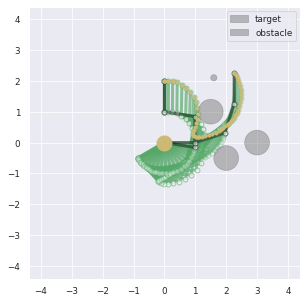

In [11]:
joint_loc = joint_loc_t[0]
x_obst_np = [x.numpy() for x in x_obst]
link_lengths_np = link_lengths.numpy()
plt=plot_chain(joint_loc=joint_loc, link_lengths=link_lengths_np, x_obst=x_obst_np, r_obst=r_obst, rect_patch=[], x_target=[], 
       batch=True, figsize=5, skip_frame=2, title=None, save_as=None, color_intensity=0.9, motion=True, alpha=0., 
           contrast=0.4, idx_highlight=[0,int(joint_loc.shape[0]-1)], lw=3, task='reaching')
plt.savefig("reach-2d-no-task-1.png",dpi=300, pad_inches=0.01,bbox_inches='tight' )